In [105]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [111]:
import h5py
import bilby
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from figaro.cosmology import CosmologicalParameters
from figaro.load import _find_redshift
import time

sns.set_theme(palette='colorblind')

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

In [40]:
# file downloaded from https://zenodo.org/records/6513631
with h5py.File('./IGWN-GWTC2p1-v2-GW150914_095045_PEDataRelease_mixed_cosmo.h5', 'r') as f:
    pd_posterior = pd.DataFrame.from_records(f['C01:IMRPhenomXPHM']['posterior_samples'][()])
    print(f['C01:IMRPhenomXPHM']['priors']['analytic']['chirp_mass'][0])

b"UniformInComponentsChirpMass(minimum=21.418182160215295, maximum=41.97447913941358, name='chirp_mass', latex_label='$\\\\mathcal{M}$', unit='$M_{\\\\odot}$', boundary=None)"


In [46]:
# Mass distributions
def mean(DL, dMdDL = 30./1000., offset = 5.):
    return DL*dMdDL + offset

def std(DL, dMdDL = 8./1000., offset = 1.):
    return DL*dMdDL + offset

def PLpeak(m, alpha = -2., mmin = 5., mmax = 70., mu = 30., sigma = 4., w = 0.2):
    norm_pl = (1-alpha)/(mmin**(alpha+1) - mmax**(alpha+1))
    pl      = norm_pl * m**alpha
    peak    = np.exp(-0.5*((m-mu)/sigma)**2)/(np.sqrt(2*np.pi)*sigma)
    return w*pl + (1-w)*peak

def evolving_gaussian(m, DL):
    mu = mean(DL)
    sigma = std(DL)
    return np.exp(-0.5*((m-mu)/sigma)**2)/(np.sqrt(2*np.pi)*sigma)

# DL distributions
def DLsq(DL, DLmax = 5000):
    return 3*DL**2/DLmax**3

def gaussian(DL, mu = 1600, sigma = 400):
    return np.exp(-0.5*((DL-mu)/sigma)**2)/(np.sqrt(2*np.pi)*sigma)

def luminosity_distance_to_redshift(distance, H0s):
    return np.array([_find_redshift(CosmologicalParameters(H0/100, 0.315, 0.685, -1, 0), distance) for H0 in H0s])

In [55]:
mz = np.linspace(10,200,1000)
dL = np.linspace(10,5000,500)

H0 = np.linspace(20,60,500)

z = luminosity_distance_to_redshift(dL, H0)

m = np.einsum("i, jk -> ikj", mz, np.reciprocal(1+z))

# p_double_gaussian = np.trapz(np.einsum("ijk, j -> ijk", evolving_gaussian(m, dL.reshape(-1,1)), gaussian(dL)), dL, axis=1)
# p_double_gaussian = p_double_gaussian/np.trapz(p_double_gaussian, mz, axis=0)

p_realistic = np.trapz(np.einsum("ijk, j -> ijk", PLpeak(m), DLsq(dL)), dL, axis=1)
p_realistic = p_realistic/np.trapz(p_realistic, mz, axis=0)

In [91]:
posterior_samples = pd_posterior['chirp_mass']
prior = bilby.gw.prior.UniformInComponentsChirpMass(minimum=mz[0], maximum=mz[-1])
prior = prior.prob(mz)

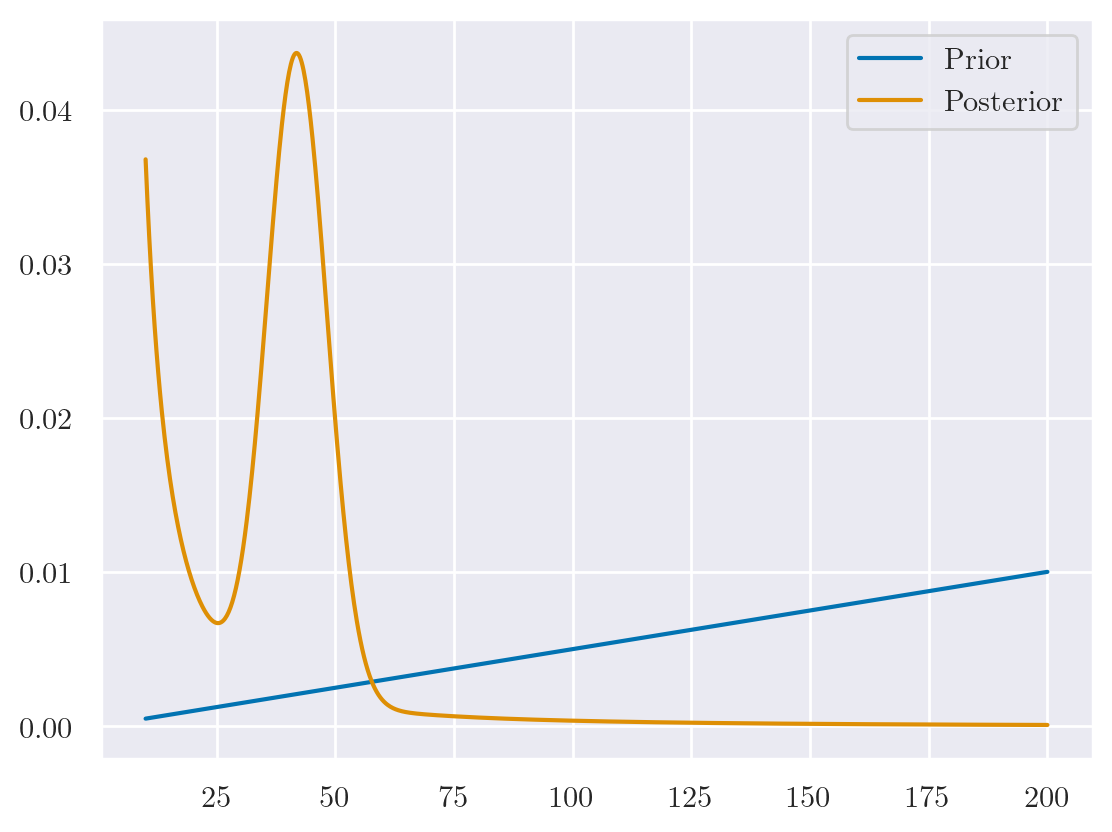

In [107]:
plt.plot(mz, prior, label='Prior')
plt.plot(mz, p_realistic[:,250], label='Posterior')
# plt.plot(mz, p_realistic[:,250]/prior)
plt.legend()

In [115]:
start = time.time()
np.array([np.interp(sample, mz, p_realistic[:,250]/prior) for sample in posterior_samples]).mean()
end = time.time()

print(f'Time taken: {end-start:.2f} s')
print(f'Number of samples: {len(posterior_samples)}')

Time taken: 0.30 s
Number of samples: 147634
